In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, Lasso
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

/home/arlisscoates/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# remove unrelated columns
drop_columns = ['id', 'member_id', 'funded_amnt', 'funded_amnt_inv', 'loan_status', 'url', 'desc', 
               'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
               'recoveries',  'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
                 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low','policy_code', 
                'application_type', 'disbursement_method', 'debt_settlement_flag',  'debt_settlement_flag_date',
                'settlement_status',  'settlement_date', 'settlement_amount', 'settlement_percentage', 
                'settlement_term', 'sec_app_inq_last_6mths', 'orig_projected_additional_accrued_interest', 
                'payment_plan_start_date','deferral_term', 'total_rec_int', 'zip_code', 'title', 'pymnt_plan',
               'addr_state', 'emp_title']

In [3]:
accepted = pd.read_csv('accepted_sample.csv', low_memory=False)
pd.set_option('display.max_columns', 999)
accepted.head()

,Unnamed: 0,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_rec_prncp,total_rec_late_fee,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,isjoint,ishardship
0,509302,6000.0,36 months,6.08,182.75,2,RENT,50000.0,Not Verified,2018,credit_card,31.88,0.0,2001,710.0,714.0,0.0,15.0,0.0,5708.0,10.1,41.0,2204.59,0.0,1.0,0.0,580.0,173984.0,0.0,8.0,0.0,2.0,16.0,168276.0,98.0,0.0,0.0,3343.0,54.0,56700.0,0.0,0.0,0.0,2.0,11599.0,45992.0,11.0,0.0,0.0,197.0,175.0,32.0,16.0,0.0,32.0,22.0,0.0,3.0,3.0,6.0,8.0,30.0,7.0,11.0,3.0,15.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,221481.0,173984.0,51700.0,164781.0,0,0
1,1402920,3000.0,36 months,13.56,101.90,10,OWN,38700.0,Not Verified,2018,other,20.50,0.0,2003,695.0,699.0,0.0,5.0,0.0,11420.0,55.2,13.0,276.65,0.0,0.0,0.0,0.0,15139.0,0.0,1.0,1.0,2.0,8.0,3719.0,39.0,1.0,1.0,4620.0,50.0,20700.0,1.0,0.0,1.0,3.0,3028.0,6480.0,41.6,0.0,0.0,171.0,180.0,8.0,8.0,0.0,8.0,8.0,0.0,1.0,3.0,2.0,2.0,7.0,4.0,6.0,3.0,5.0,0.0,0.0,0.0,2.0,92.3,50.0,0.0,0.0,30263.0,15139.0,11100.0,9563.0,1,0
2,471817,4125.0,36 months,16.02,145.07,8,OWN,30000.0,Source Verified,2018,other,37.96,0.0,2001,715.0,719.0,0.0,11.0,1.0,14895.0,31.3,27.0,1580.18,0.0,0.0,0.0,50.0,118095.0,0.0,2.0,0.0,0.0,33.0,16401.0,49.0,0.0,3.0,6271.0,39.0,47600.0,0.0,0.0,0.0,3.0,13122.0,22643.0,39.1,0.0,0.0,115.0,204.0,17.0,17.0,3.0,17.0,24.0,1.0,3.0,4.0,3.0,9.0,5.0,8.0,17.0,4.0,10.0,0.0,0.0,0.0,0.0,96.3,33.3,0.0,1.0,171643.0,31296.0,37200.0,33710.0,0,0
3,1542987,10000.0,36 months,11.05,327.63,0,RENT,29000.0,Not Verified,2018,other,31.37,0.0,2005,795.0,799.0,0.0,10.0,0.0,2902.0,12.3,28.0,2455.51,0.0,0.0,0.0,0.0,7256.0,1.0,2.0,0.0,0.0,26.0,4354.0,19.0,1.0,2.0,2049.0,16.0,23500.0,0.0,4.0,0.0,2.0,806.0,16651.0,11.0,0.0,0.0,150.0,150.0,5.0,5.0,2.0,5.0,0.0,0.0,1.0,2.0,5.0,8.0,5.0,8.0,21.0,2.0,10.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,45961.0,7256.0,18700.0,22461.0,1,0
4,451689,6000.0,36 months,6.71,184.47,10,MORTGAGE,79000.0,Not Verified,2018,home_improvement,20.25,0.0,1998,745.0,749.0,0.0,15.0,0.0,6068.0,18.2,36.0,1867.79,0.0,0.0,0.0,0.0,93826.0,2.0,4.0,1.0,2.0,7.0,20805.0,35.0,3.0,3.0,2281.0,29.0,33300.0,0.0,0.0,2.0,5.0,6255.0,24232.0,20.0,0.0,0.0,159.0,237.0,2.0,2.0,5.0,2.0,8.0,0.0,6.0,6.0,8.0,9.0,19.0,10.0,12.0,6.0,15.0,0.0,0.0,0.0,4.0,94.4,0.0,0.0,0.0,168692.0,26873.0,30300.0,60175.0,0,0


In [4]:
list(accepted.columns)

['Unnamed: 0',
 'loan_amnt',
 'term',
 'int_rate',
 'installment',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'purpose',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'total_rec_prncp',
 'total_rec_late_fee',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd'

### Missing Values

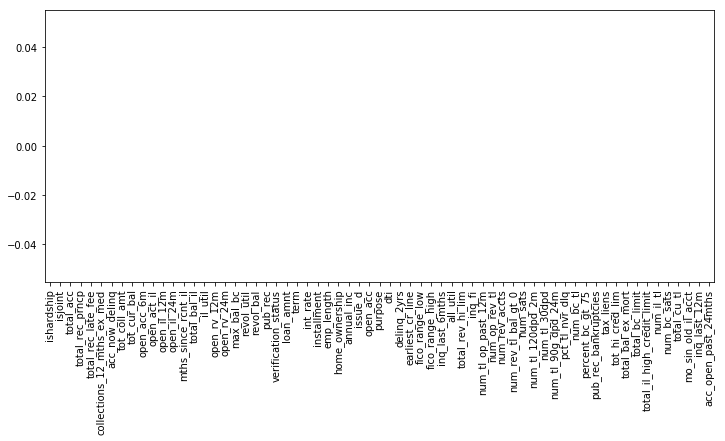

In [5]:
accepted.isna().mean().sort_values(ascending=False).head(65).plot(kind='bar', figsize=(12,5))

Majority of variables related to joint applications are NAN. Therefore, we create a dummy variable for joint application and remove all variables for joint application as most values are NAN.

In [6]:
accepted['isjoint'] = 1*(~accepted['sec_app_fico_range_high'].isna())

KeyError: 'sec_app_fico_range_high'

In [ ]:
sec_columns = accepted.columns[accepted.columns.str.contains('sec_app')]
sec_columns = np.hstack((sec_columns, accepted.columns[accepted.columns.str.contains('_joint')]))
accepted.drop(columns = sec_columns, inplace=True)
sec_columns

Similarly for hardship variables. Most applicant didn't have hardship status. We create a dummy to refelct whether a person had hardship before or not and remove the hardship related columns

In [ ]:
accepted['ishardship'] = 1*(~accepted['hardship_end_date'].isna())

In [7]:
hard_columns = accepted.columns[accepted.columns.str.contains('hardship_')]
accepted.drop(columns = hard_columns, inplace=True)
hard_columns

Index([], dtype='object')

For the remaining variables, we replace NaN values with zero

In [8]:
accepted = accepted.fillna(0)

### Data Type

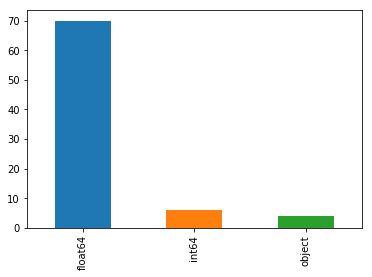

In [9]:
accepted.dtypes.value_counts().plot(kind='bar');

### Data Cleaning

Convert employement length from string to numeric by extracting numbers

In [10]:
accepted['emp_length'] = accepted['emp_length'].str.extract('(\d+)')[0].fillna(0).astype(int)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

Extract the year from earliest_cr_line

In [11]:
accepted['earliest_cr_line'] = accepted['earliest_cr_line'].str.extract('(\d+)')[0].fillna(2018).astype(int)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

Extract the year from issue_d

In [12]:
accepted['issue_d'] = accepted['issue_d'].str.extract('(\d+)')[0].fillna(2018).astype(int)

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

### EDA

Distribution of interest rate, majority of loan have interest rate between 7% to 15%

/home/arlisscoates/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


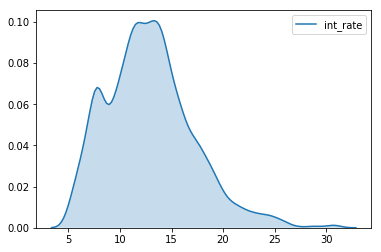

In [13]:
sns.kdeplot(accepted['int_rate'], shade=True)

Correlation between target and numeric columns

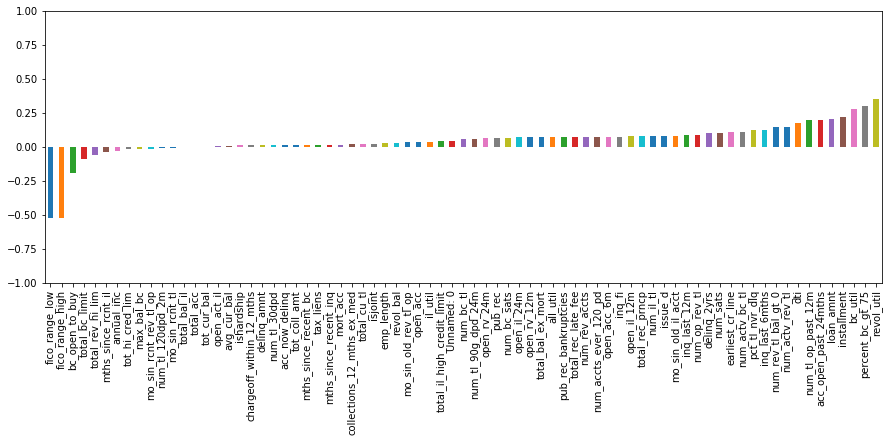

In [14]:
accepted.drop(columns=['int_rate']).corrwith(accepted['int_rate']).\
            sort_values().dropna().plot(kind='bar', figsize=(15,5))
plt.ylim([-1, 1]);

Among features, Fico scores and the number of accounts opened in past 12 months have the highest correlation with the target. Fico score has negative correlation which means that higher Fico score leads to lower interest rate. On the other hand, number of account has positive correlation which means that if a person has opened many account during the last 12 months, his interest rate would be higher

This figure shows that longer loan duration leads to higher insterest rate

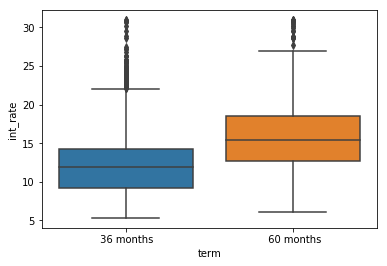

In [15]:
sns.boxplot(x='term', y='int_rate', data=accepted);

Lending club uses a model to assing borrower a grade based on their profile. Grade A has the lowest risk for the investor and grade G has the highest. Below figure shows that the interest rate is highly correlated with borower grade

In [16]:
sns.boxplot(x='grade', y='int_rate', data=accepted.sort_values('grade'));

KeyError: 'grade'

This figure shows the correlation between loan amount and interest rate. Higher loan amounts tend to have higher interest rate

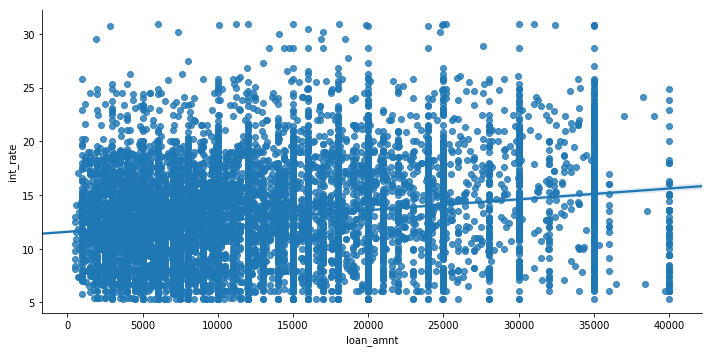

In [17]:
sns.lmplot(x='loan_amnt', y='int_rate', data=accepted,height=5, aspect=2)

FICO score is impacting interest rate for the borower. Better FICO score (higher values) leads to lower interest rate

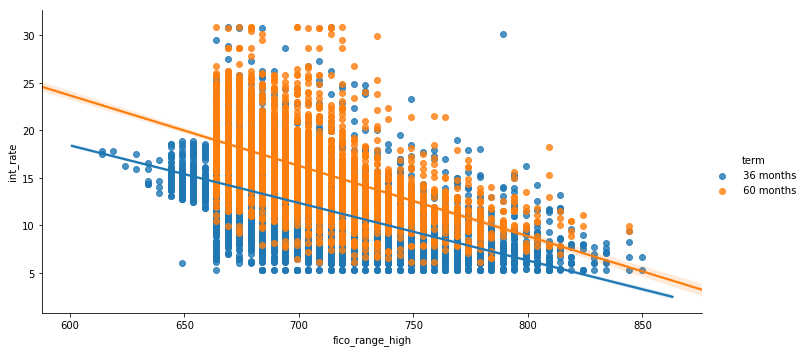

In [18]:
sns.lmplot(x='fico_range_high', y='int_rate', hue='term', data=accepted,height=5, aspect=2)

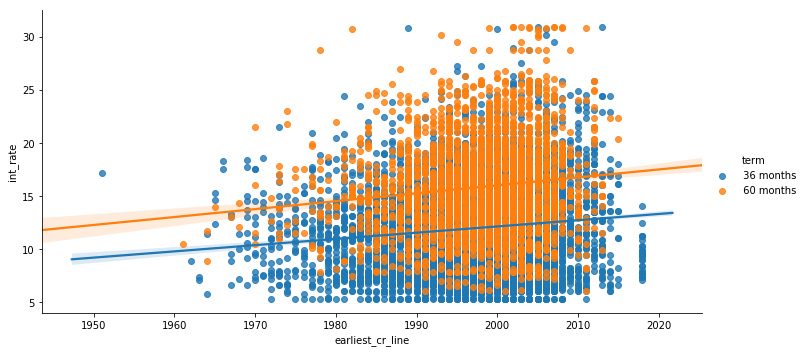

In [19]:
sns.lmplot(x='earliest_cr_line', y='int_rate', hue='term', data=accepted,height=5, aspect=2)

Interest Rate versus year, the interest rate is also a function of nationwide economy which varies over time

([<matplotlib.axis.XTick at 0x7f6f5af3eda0>,
 <a list of 12 Text xticklabel objects>)

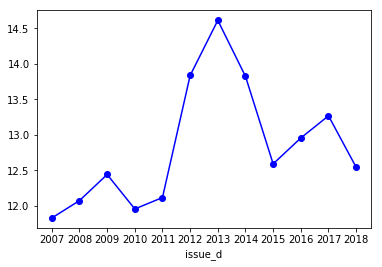

In [20]:
accepted.groupby('issue_d')['int_rate'].mean().plot(style='bo-')
plt.xticks(accepted['issue_d'].unique())

The following figure shows the interest rate for different loan purpose. It shows that certain loan purpose has lower interest rate such as buying a car due to lower risk to the investors

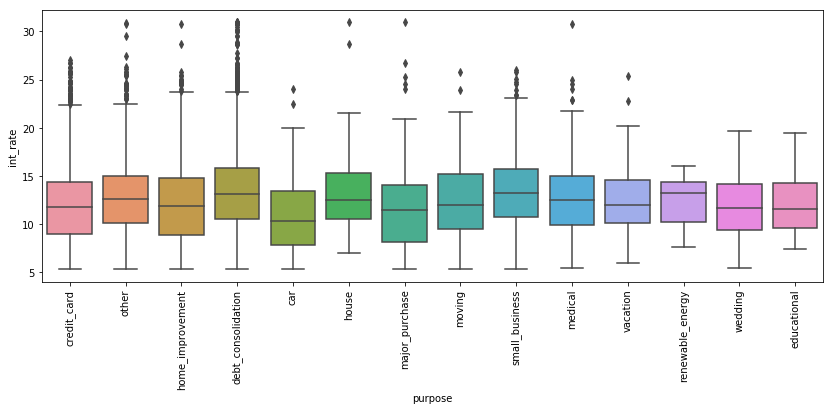

In [21]:
plt.figure(figsize=(14,5))
sns.boxplot(x='purpose', y='int_rate', data=accepted);
plt.xticks(rotation=90);

In the following figure the distirbution of interest rate for different home ownership status is depicted. Borrowers who are renting tend to have higher interest rate on their loan application. This is due to the fact that home owners (or people with mortgage) carry less task to the investors, as their home can be later used as a collateral to repay the loan

Text(0,0.5,'Distribution')

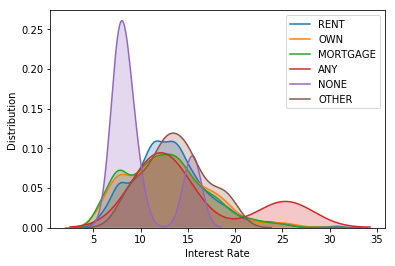

In [22]:
for item in accepted['home_ownership'].unique():
    sns.kdeplot(accepted[accepted['home_ownership'] == item]['int_rate'], label = item, shade=True)
plt.xlabel('Interest Rate')
plt.ylabel('Distribution')

## Modeling

In [23]:
accepted = accepted.drop(columns=['grade', 'sub_grade', 'installment'])

KeyError: "['grade' 'sub_grade'] not found in axis"

In [24]:
accepted_dummy = pd.get_dummies(accepted)
X_train = accepted_dummy.drop(columns='int_rate')

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X_train)
y = accepted_dummy['int_rate'].values
print(X.shape)

### Outlier Detection Using Linear Regression

We fit a linear regression model on the selected features and then caluclate the residual for each observation on the dataset. The residuals versus fitted values are plotted and outliers are idenitfied. Below figure shows that there is one outlier in our dataset. It also shows that there is a non-linear trend in the residuals which is not captured by the linear model. Therefore, we expect that the linear model does not perform well in this problem

In [ ]:
lin = LinearRegression()
lin.fit(X, y);
fitted = lin.predict(X)
res = y - fitted
outlier = abs(res) > 15
plt.plot(fitted, res, 'ko', alpha = 0.1)
plt.plot(fitted[outlier], res[outlier], 'ro')
plt.xlabel('Fitted Value')
plt.ylabel('Residual');

Outliers are removed from the dataset

In [ ]:
X = X[~outlier,:]
y = y[~outlier]

### Linear Regression Feature Selection

We use stepwise feature selection with cross-validation and a linear regression model

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=123)
lin = LinearRegression()
rfecv = RFECV(estimator=lin, step=1, cv=kf, scoring='neg_mean_squared_error')
rfecv.fit(X, y)

In [ ]:
selected = rfecv.get_support()
indx = np.argmin(-rfecv.grid_scores_)

plt.plot(range(1, len(rfecv.grid_scores_) + 1), -rfecv.grid_scores_, 'bo-')
plt.plot(range(1, len(rfecv.grid_scores_) + 1)[indx], -rfecv.grid_scores_[indx], 'ro')
plt.yscale('log')
plt.xlabel('Number of Features')
plt.ylabel('RMSE');

Stepwise feature selection has selected 70 features with the lowest RMSE

In [ ]:
selected.sum()

### Lasso Feature Selection

In [ ]:
lasso_cv = LassoCV(cv=10, random_state=123, max_iter = 400, tol =1e-2)
lasso_cv.fit(X,y);

In [ ]:
lasso_mse = lasso_cv.mse_path_.mean(axis=1)
plt.plot(lasso_cv.alphas_, lasso_mse, 'b-')
plt.plot(lasso_cv.alphas_[lasso_mse.argmin()], lasso_mse[lasso_mse.argmin()], 'ro')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE');
plt.title('Optimal Lasso: {0:.3f}'.format(lasso_cv.alphas_[lasso_mse.argmin()]));

In [ ]:
lasso = Lasso(alpha = lasso_cv.alphas_[lasso_mse.argmin()])
lasso.fit(X,y);
selected_lasso = np.abs(lasso.coef_) > 0.1
lasso_df = pd.Series(lasso.coef_[selected_lasso], index=X_train.columns[selected_lasso])
lasso_df.sort_values().plot(kind='bar', figsize=(15,5));

### Random Forest Feature Importance

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X,y)
imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
imp.head(50).plot(kind='bar', figsize=(15,5));

### Cross Validation and Model Selection

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=123)

In [ ]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=8)
gb_scores = cross_val_score(gb, X, y, cv=kf, scoring='r2')

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')

In [ ]:
lin = LinearRegression()
lin_scores = cross_val_score(lin, X[:,selected], y, cv=kf, scoring='r2')

In [ ]:
svr = SVR(gamma='auto')
svr_scores = cross_val_score(svr, X[:,selected], y, cv=kf, scoring='r2')

In [ ]:
tree = DecisionTreeRegressor()
tree_scores = cross_val_score(tree, X, y, cv=kf, scoring='r2')

In [ ]:
lasso = Lasso(alpha = lasso_cv.alphas_[lasso_mse.argmin()])
lasso_scores = cross_val_score(tree, X, y, cv=kf, scoring='r2')

In [ ]:
res = pd.DataFrame({'gb': gb_scores, 'rf': rf_scores, 'lin': lin_scores, 'svr': svr_scores, 
                    'tree': tree_scores, 'lasso': lasso_scores})
res

In [ ]:
sns.barplot(x="model", y="r2", data=res.melt(var_name='model', value_name='r2'));

### Model Optimization

From above cross-validation, we can se Gradient Boosting has the highest R2 value and outperforms other model. In the following section, we use grid search CV method to optimize the hyperparamteres of the Gradient Boosting model and improve its performance

In [ ]:
params = {'n_estimators': [100, 150, 200],
          'max_depth': [4, 6, 8],
          'max_features': ['sqrt', 'log2']}
gb = GradientBoostingRegressor(random_state = 123)
grid = GridSearchCV(gb, params, cv=3, n_jobs=4, scoring='r2')
grid.fit(X,y);
grid.best_estimator_

In [ ]:
gb_scores = cross_val_score(grid.best_estimator_, X, y, cv=kf, scoring='r2')
print('Best Model R2: {0:.2f} +- {1:.2f}'.format(gb_scores.mean(), gb_scores.std()))

The GB with 200 estimators, max_depth of 4, max_feature of 'sqrt' has the optimal performance. The cross-validation shows the R2 of 0.65 which is better than our plain GB